In [8]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd /content/drive/MyDrive/BloodCellObjectDetection/
# clone the repository
!git clone "https://github.com/WongKinYiu/yolov7"
%cd yolov7

/content/drive/MyDrive/BloodCellObjectDetection
Cloning into 'yolov7'...
remote: Enumerating objects: 998, done.
remote: Total 998 (delta 0), reused 0 (delta 0), pack-reused 998
Receiving objects: 100% (998/998), 69.77 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (465/465), done.
Checking out files: 100% (104/104), done.
/content/drive/MyDrive/BloodCellObjectDetection/yolov7


In [4]:
# isntall the dependencies required
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 31.9 MB/s 
Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [5]:
#Data configuration file
%cat /content/drive/MyDrive/BloodCellObjectDetection/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [6]:
#Set the number of classes based on the above config file
import yaml
with open("/content/drive/MyDrive/BloodCellObjectDetection/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc']) 

In [8]:
#YOLOv7 tiny architecture
%cat /content/drive/MyDrive/BloodCellObjectDetection/yolov7/cfg/training/yolov7-tiny.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2  
  
   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4    
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
   
   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/drive/MyDrive/BloodCellObjectDetection/yolov7/cfg/training/yolov7-tiny.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2  
  
   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4    
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
   
   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14
   
   [-1, 1, MP, []],  # 15-P4/16
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21
   
   [-1, 1, MP, []],  # 22-P5/32
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]

# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, SP, [5]],
   [-2, 1, SP, [9]],
   [-3, 1, SP, [13]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -7], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37
  
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47
  
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57
   
   [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 47], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65
   
   [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 37], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73
      
   [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],

   [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [14]:
%%time
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg /training/yolov7-tiny.yaml --weights '' --name yolov7-tiny  --cache

YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=True, cfg='./cfg/training/yolov7-tiny.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7-tiny', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov7-tiny', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, wa

In [15]:
%%capture

!python /content/drive/MyDrive/BloodCellObjectDetection/yolov7/detect.py --weights runs/train/yolov7-tiny/weights/best.pt --img 416 --conf 0.40 --source /content/drive/MyDrive/BloodCellObjectDetection/test/images

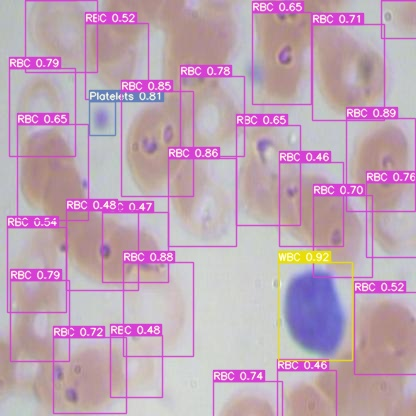

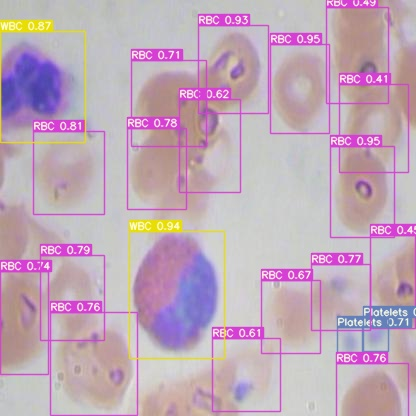

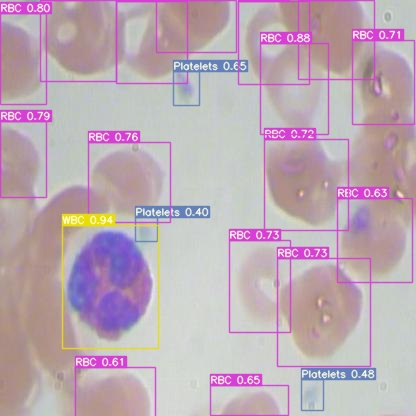

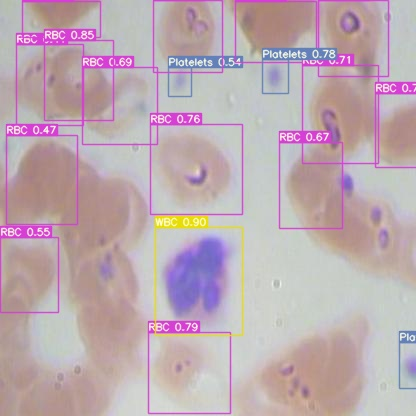

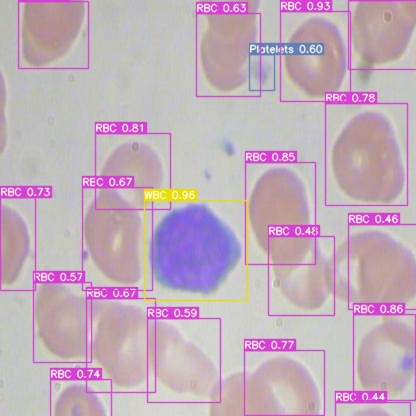

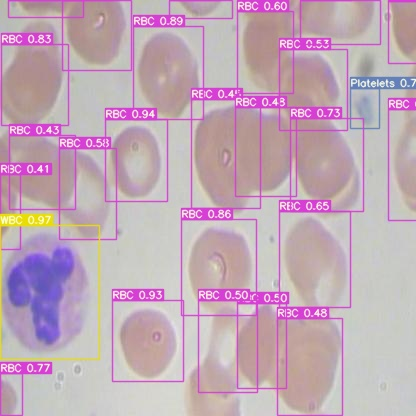

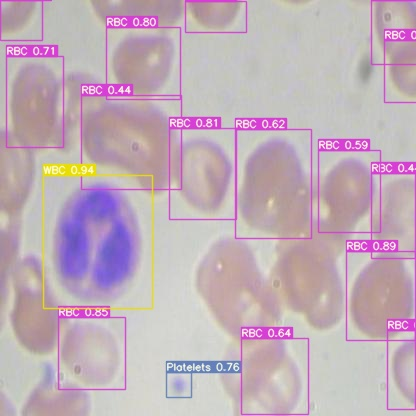

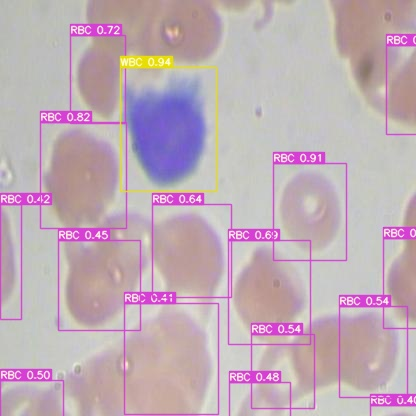

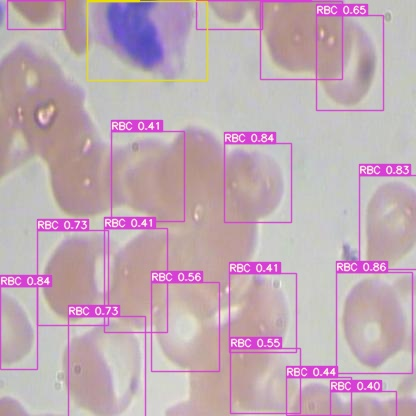

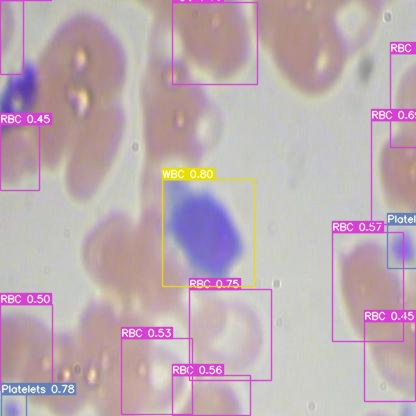

In [18]:
import glob
for images in glob.glob('/content/drive/MyDrive/BloodCellObjectDetection/yolov7/runs/detect/exp/*.jpg')[0:10]:
    display(Image(filename=images))